In [1]:
import paddle.v2 as paddle
paddle.init(use_gpu=False)
movie_info = paddle.dataset.movielens.movie_info()
print movie_info.values()[0]
user_info = paddle.dataset.movielens.user_info()
print user_info.values()[0]

<MovieInfo id(1), title(Toy Story ), categories(['Animation', "Children's", 'Comedy'])>
<UserInfo id(1), gender(F), age(1), job(10)>


In [5]:
train_set_creator = paddle.dataset.movielens.train()
train_sample = next(train_set_creator())
uid = train_sample[0]
mov_id = train_sample[len(user_info[uid].value())]
print "User %s rates Movie %s with Score %s"%(user_info[uid], movie_info[mov_id], train_sample[-1])

User <UserInfo id(1), gender(F), age(1), job(10)> rates Movie <MovieInfo id(1193), title(One Flew Over the Cuckoo's Nest ), categories(['Drama'])> with Score [5.0]


In [3]:
uid = paddle.layer.data(
    name='user_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_user_id() + 1))
usr_emb = paddle.layer.embedding(input=uid, size=32)
usr_fc = paddle.layer.fc(input=usr_emb, size=32)

usr_gender_id = paddle.layer.data(
    name='gender_id', type=paddle.data_type.integer_value(2))
usr_gender_emb = paddle.layer.embedding(input=usr_gender_id, size=16)
usr_gender_fc = paddle.layer.fc(input=usr_gender_emb, size=16)

usr_age_id = paddle.layer.data(
    name='age_id',
    type=paddle.data_type.integer_value(
        len(paddle.dataset.movielens.age_table)))
usr_age_emb = paddle.layer.embedding(input=usr_age_id, size=16)
usr_age_fc = paddle.layer.fc(input=usr_age_emb, size=16)

usr_job_id = paddle.layer.data(
    name='job_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_job_id() + 1))
usr_job_emb = paddle.layer.embedding(input=usr_job_id, size=16)
usr_job_fc = paddle.layer.fc(input=usr_job_emb, size=16)

In [6]:
usr_combined_features = paddle.layer.fc(
        input=[usr_fc, usr_gender_fc, usr_age_fc, usr_job_fc],
        size=200,
        act=paddle.activation.Tanh())

In [7]:
mov_id = paddle.layer.data(
    name='movie_id',
    type=paddle.data_type.integer_value(
        paddle.dataset.movielens.max_movie_id() + 1))
mov_emb = paddle.layer.embedding(input=mov_id, size=32)
mov_fc = paddle.layer.fc(input=mov_emb, size=32)

mov_categories = paddle.layer.data(
    name='category_id',
    type=paddle.data_type.sparse_binary_vector(
        len(paddle.dataset.movielens.movie_categories())))
mov_categories_hidden = paddle.layer.fc(input=mov_categories, size=32)

movie_title_dict = paddle.dataset.movielens.get_movie_title_dict()
mov_title_id = paddle.layer.data(
    name='movie_title',
    type=paddle.data_type.integer_value_sequence(len(movie_title_dict)))
mov_title_emb = paddle.layer.embedding(input=mov_title_id, size=32)
mov_title_conv = paddle.networks.sequence_conv_pool(
    input=mov_title_emb, hidden_size=32, context_len=3)

mov_combined_features = paddle.layer.fc(
    input=[mov_fc, mov_categories_hidden, mov_title_conv],
    size=200,
    act=paddle.activation.Relu())

In [8]:
inference = paddle.layer.cos_sim(a=usr_combined_features, b=mov_combined_features, size=1, scale=5)

In [15]:
cost = paddle.layer.square_error_cost(
        input=inference,
        label=paddle.layer.data(name='scores', type=paddle.data_type.dense_vector(1)))
parameters = paddle.parameters.create(cost)
print parameters.keys()

[u'___embedding_0__.w0', u'___fc_layer_0__.w0', u'___fc_layer_0__.wbias', u'___embedding_1__.w0', u'___fc_layer_1__.w0', u'___fc_layer_1__.wbias', u'___embedding_2__.w0', u'___fc_layer_2__.w0', u'___fc_layer_2__.wbias', u'___embedding_3__.w0', u'___fc_layer_3__.w0', u'___fc_layer_3__.wbias', u'___fc_layer_4__.w0', u'___fc_layer_4__.w1', u'___fc_layer_4__.w2', u'___fc_layer_4__.w3', u'___fc_layer_4__.wbias', u'___embedding_4__.w0', u'___fc_layer_5__.w0', u'___fc_layer_5__.wbias', u'___fc_layer_6__.w0', u'___fc_layer_6__.wbias', u'___embedding_5__.w0', u'___sequence_conv_pooling_0___conv_fc.w0', u'___sequence_conv_pooling_0___conv_fc.wbias', u'___fc_layer_7__.w0', u'___fc_layer_7__.w1', u'___fc_layer_7__.w2', u'___fc_layer_7__.wbias']


In [16]:
trainer = paddle.trainer.SGD(cost=cost, parameters=parameters,
                            update_equation=paddle.optimizer.Adam(learning_rate=1e-4))

In [19]:
feeding = {
    'user_id': 0,
    'gender_id': 1,
    'age_id': 2,
    'job_id': 3,
    'movie_id': 4,
    'category_id': 5,
    'movie_title': 6,
    'scores': 7
}

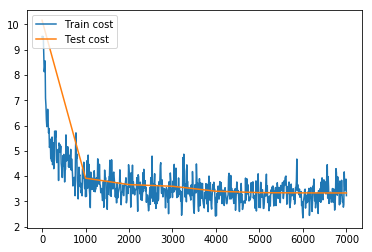

In [20]:
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
cost_ploter = Ploter(train_title, test_title)
step = 0

def event_handler(event):
    if isinstance(event, paddle.event.EndIteration):
        if event.batch_id % 100 == 0:
            print "Pass %d Batch %d Cost %.2f" % (
                event.pass_id, event.batch_id, event.cost)
            
def event_handler_plot(event):
    global step
    if isinstance(event, paddle.event.EndIteration):
        if step % 10 == 0:  # every 10 batches, record a train cost
            cost_ploter.append(train_title, step, event.cost)

        if step % 1000 == 0: # every 1000 batches, record a test cost
            result = trainer.test(
                reader=paddle.batch(
                    paddle.dataset.movielens.test(), batch_size=256),
                feeding=feeding)
            cost_ploter.append(test_title, step, result.cost)

        if step % 100 == 0: # every 100 batches, update cost plot
            cost_ploter.plot()
        step += 1
    
trainer.train(
    reader=paddle.batch(
            paddle.reader.shuffle(
            paddle.dataset.movielens.train(), buf_size=8192),
                            batch_size=256),
    event_handler=event_handler_plot,
    feeding=feeding,
    num_passes=2)

In [51]:
import copy
user_id = 234
#movie_id = 2
for movie_id in movie_info.keys():
    rank = dict()
    user = user_info[user_id]
    movie = movie_info[movie_id]

    feature = user.value() + movie.value()

    infer_dict = copy.copy(feeding)
    del infer_dict['scores']
    prediction = paddle.infer(inference, parameters=parameters, input=[feature], feeding=infer_dict)
    print prediction
    score = (prediction[0][0] + 5.0) / 2
    print "[Predict] User %d Rating Movie %d With Score %.2f"%(user_id, movie_id, score)

[[ 3.95785832]]
[Predict] User 234 Rating Movie 1 With Score 4.48
[[ 2.25901818]]
[Predict] User 234 Rating Movie 2 With Score 3.63
[[ 1.47981632]]
[Predict] User 234 Rating Movie 3 With Score 3.24
[[ 1.32090425]]
[Predict] User 234 Rating Movie 4 With Score 3.16
[[ 1.44131851]]
[Predict] User 234 Rating Movie 5 With Score 3.22
[[ 3.57275295]]
[Predict] User 234 Rating Movie 6 With Score 4.29
[[ 2.39062357]]
[Predict] User 234 Rating Movie 7 With Score 3.70
[[ 2.03619099]]
[Predict] User 234 Rating Movie 8 With Score 3.52
[[ 1.03048003]]
[Predict] User 234 Rating Movie 9 With Score 3.02
[[ 2.61829162]]
[Predict] User 234 Rating Movie 10 With Score 3.81
[[ 3.18158889]]
[Predict] User 234 Rating Movie 11 With Score 4.09
[[ 0.40216148]]
[Predict] User 234 Rating Movie 12 With Score 2.70
[[ 2.62963176]]
[Predict] User 234 Rating Movie 13 With Score 3.81
[[ 2.97981262]]
[Predict] User 234 Rating Movie 14 With Score 3.99
[[ 1.01568317]]
[Predict] User 234 Rating Movie 15 With Score 3.01
[[ 3

[[ 2.29950881]]
[Predict] User 234 Rating Movie 133 With Score 3.65
[[ 3.51298141]]
[Predict] User 234 Rating Movie 134 With Score 4.26
[[ 0.99997747]]
[Predict] User 234 Rating Movie 135 With Score 3.00
[[ 2.97674584]]
[Predict] User 234 Rating Movie 136 With Score 3.99
[[ 2.37662387]]
[Predict] User 234 Rating Movie 137 With Score 3.69
[[ 2.60111237]]
[Predict] User 234 Rating Movie 138 With Score 3.80
[[ 2.41742253]]
[Predict] User 234 Rating Movie 139 With Score 3.71
[[ 2.03780246]]
[Predict] User 234 Rating Movie 140 With Score 3.52
[[ 2.86695027]]
[Predict] User 234 Rating Movie 141 With Score 3.93
[[ 2.41554523]]
[Predict] User 234 Rating Movie 142 With Score 3.71
[[ 3.18806028]]
[Predict] User 234 Rating Movie 143 With Score 4.09
[[ 2.70789552]]
[Predict] User 234 Rating Movie 144 With Score 3.85
[[ 2.40130043]]
[Predict] User 234 Rating Movie 145 With Score 3.70
[[ 1.49052]]
[Predict] User 234 Rating Movie 146 With Score 3.25
[[ 3.16570282]]
[Predict] User 234 Rating Movie 147

[Predict] User 234 Rating Movie 256 With Score 3.13
[[ 2.49181914]]
[Predict] User 234 Rating Movie 257 With Score 3.75
[[ 0.57808769]]
[Predict] User 234 Rating Movie 258 With Score 2.79
[[ 1.69673157]]
[Predict] User 234 Rating Movie 259 With Score 3.35
[[ 4.27263355]]
[Predict] User 234 Rating Movie 260 With Score 4.64
[[ 2.87736464]]
[Predict] User 234 Rating Movie 261 With Score 3.94
[[ 3.34629226]]
[Predict] User 234 Rating Movie 262 With Score 4.17
[[ 3.30464959]]
[Predict] User 234 Rating Movie 263 With Score 4.15
[[ 2.82467008]]
[Predict] User 234 Rating Movie 264 With Score 3.91
[[ 3.46285391]]
[Predict] User 234 Rating Movie 265 With Score 4.23
[[ 2.47529459]]
[Predict] User 234 Rating Movie 266 With Score 3.74
[[ 0.84132695]]
[Predict] User 234 Rating Movie 267 With Score 2.92
[[ 2.71483517]]
[Predict] User 234 Rating Movie 268 With Score 3.86
[[ 2.85602307]]
[Predict] User 234 Rating Movie 269 With Score 3.93
[[ 1.8491956]]
[Predict] User 234 Rating Movie 270 With Score 3.

[[ 1.47701049]]
[Predict] User 234 Rating Movie 379 With Score 3.24
[[ 2.86063123]]
[Predict] User 234 Rating Movie 380 With Score 3.93
[[ 2.1050005]]
[Predict] User 234 Rating Movie 381 With Score 3.55
[[ 1.59252846]]
[Predict] User 234 Rating Movie 382 With Score 3.30
[[ 2.32393909]]
[Predict] User 234 Rating Movie 383 With Score 3.66
[[ 1.76594245]]
[Predict] User 234 Rating Movie 384 With Score 3.38
[[ 2.79117227]]
[Predict] User 234 Rating Movie 385 With Score 3.90
[[ 1.22630692]]
[Predict] User 234 Rating Movie 386 With Score 3.11
[[ 1.19598913]]
[Predict] User 234 Rating Movie 387 With Score 3.10
[[ 3.20524311]]
[Predict] User 234 Rating Movie 388 With Score 4.10
[[ 3.0546329]]
[Predict] User 234 Rating Movie 389 With Score 4.03
[[ 2.73676181]]
[Predict] User 234 Rating Movie 390 With Score 3.87
[[ 2.31584597]]
[Predict] User 234 Rating Movie 391 With Score 3.66
[[ 1.74164045]]
[Predict] User 234 Rating Movie 392 With Score 3.37
[[-0.17992114]]
[Predict] User 234 Rating Movie 39

[[ 2.9659338]]
[Predict] User 234 Rating Movie 509 With Score 3.98
[[ 0.95690864]]
[Predict] User 234 Rating Movie 510 With Score 2.98
[[ 2.1303668]]
[Predict] User 234 Rating Movie 511 With Score 3.57
[[ 1.69432175]]
[Predict] User 234 Rating Movie 512 With Score 3.35
[[ 1.65736985]]
[Predict] User 234 Rating Movie 513 With Score 3.33
[[ 2.81598926]]
[Predict] User 234 Rating Movie 514 With Score 3.91
[[ 3.50495195]]
[Predict] User 234 Rating Movie 515 With Score 4.25
[[ 1.51348722]]
[Predict] User 234 Rating Movie 516 With Score 3.26
[[ 1.96639729]]
[Predict] User 234 Rating Movie 517 With Score 3.48
[[ 0.81649917]]
[Predict] User 234 Rating Movie 518 With Score 2.91
[[-0.0976226]]
[Predict] User 234 Rating Movie 519 With Score 2.45
[[ 1.087991]]
[Predict] User 234 Rating Movie 520 With Score 3.04
[[ 2.63534141]]
[Predict] User 234 Rating Movie 521 With Score 3.82
[[ 3.01724648]]
[Predict] User 234 Rating Movie 522 With Score 4.01
[[ 3.37850952]]
[Predict] User 234 Rating Movie 523 W

[[ 0.37904108]]
[Predict] User 234 Rating Movie 631 With Score 2.69
[[ 3.46814799]]
[Predict] User 234 Rating Movie 632 With Score 4.23
[[ 2.98142624]]
[Predict] User 234 Rating Movie 633 With Score 3.99
[[ 1.0523746]]
[Predict] User 234 Rating Movie 634 With Score 3.03
[[ 3.07592368]]
[Predict] User 234 Rating Movie 635 With Score 4.04
[[ 2.5998261]]
[Predict] User 234 Rating Movie 636 With Score 3.80
[[ 0.4836942]]
[Predict] User 234 Rating Movie 637 With Score 2.74
[[ 2.55200052]]
[Predict] User 234 Rating Movie 638 With Score 3.78
[[ 1.30710638]]
[Predict] User 234 Rating Movie 639 With Score 3.15
[[ 1.5693357]]
[Predict] User 234 Rating Movie 640 With Score 3.28
[[ 2.26849461]]
[Predict] User 234 Rating Movie 641 With Score 3.63
[[ 2.3893981]]
[Predict] User 234 Rating Movie 642 With Score 3.69
[[ 1.21872091]]
[Predict] User 234 Rating Movie 643 With Score 3.11
[[ 1.66338062]]
[Predict] User 234 Rating Movie 644 With Score 3.33
[[ 3.00113201]]
[Predict] User 234 Rating Movie 645 W

[Predict] User 234 Rating Movie 763 With Score 3.90
[[ 2.39081359]]
[Predict] User 234 Rating Movie 764 With Score 3.70
[[ 1.03364921]]
[Predict] User 234 Rating Movie 765 With Score 3.02
[[ 2.87031436]]
[Predict] User 234 Rating Movie 766 With Score 3.94
[[ 2.33334637]]
[Predict] User 234 Rating Movie 767 With Score 3.67
[[ 2.93814731]]
[Predict] User 234 Rating Movie 768 With Score 3.97
[[ 2.55892301]]
[Predict] User 234 Rating Movie 769 With Score 3.78
[[ 2.81167912]]
[Predict] User 234 Rating Movie 770 With Score 3.91
[[ 2.95206809]]
[Predict] User 234 Rating Movie 771 With Score 3.98
[[ 2.20136189]]
[Predict] User 234 Rating Movie 772 With Score 3.60
[[ 2.80987024]]
[Predict] User 234 Rating Movie 773 With Score 3.90
[[ 2.77489591]]
[Predict] User 234 Rating Movie 774 With Score 3.89
[[ 2.45822096]]
[Predict] User 234 Rating Movie 775 With Score 3.73
[[ 2.3597877]]
[Predict] User 234 Rating Movie 776 With Score 3.68
[[ 2.99182343]]
[Predict] User 234 Rating Movie 777 With Score 4.

[Predict] User 234 Rating Movie 897 With Score 4.07
[[ 4.03715181]]
[Predict] User 234 Rating Movie 898 With Score 4.52
[[ 3.93623829]]
[Predict] User 234 Rating Movie 899 With Score 4.47
[[ 3.24275255]]
[Predict] User 234 Rating Movie 900 With Score 4.12
[[ 2.82342219]]
[Predict] User 234 Rating Movie 901 With Score 3.91
[[ 3.34490943]]
[Predict] User 234 Rating Movie 902 With Score 4.17
[[ 4.1123147]]
[Predict] User 234 Rating Movie 903 With Score 4.56
[[ 4.28439426]]
[Predict] User 234 Rating Movie 904 With Score 4.64
[[ 4.00005484]]
[Predict] User 234 Rating Movie 905 With Score 4.50
[[ 3.80556464]]
[Predict] User 234 Rating Movie 906 With Score 4.40
[[ 3.61310983]]
[Predict] User 234 Rating Movie 907 With Score 4.31
[[ 4.30116796]]
[Predict] User 234 Rating Movie 908 With Score 4.65
[[ 3.93809223]]
[Predict] User 234 Rating Movie 909 With Score 4.47
[[ 3.98919797]]
[Predict] User 234 Rating Movie 910 With Score 4.49
[[ 3.8720212]]
[Predict] User 234 Rating Movie 911 With Score 4.4

[Predict] User 234 Rating Movie 1025 With Score 3.97
[[ 2.8571794]]
[Predict] User 234 Rating Movie 1026 With Score 3.93
[[ 2.22897935]]
[Predict] User 234 Rating Movie 1027 With Score 3.61
[[ 3.40651488]]
[Predict] User 234 Rating Movie 1028 With Score 4.20
[[ 3.07611489]]
[Predict] User 234 Rating Movie 1029 With Score 4.04
[[ 1.91836751]]
[Predict] User 234 Rating Movie 1030 With Score 3.46
[[ 2.71294951]]
[Predict] User 234 Rating Movie 1031 With Score 3.86
[[ 3.06228423]]
[Predict] User 234 Rating Movie 1032 With Score 4.03
[[ 2.85914612]]
[Predict] User 234 Rating Movie 1033 With Score 3.93
[[ 2.95012736]]
[Predict] User 234 Rating Movie 1034 With Score 3.98
[[ 3.34806299]]
[Predict] User 234 Rating Movie 1035 With Score 4.17
[[ 3.8254292]]
[Predict] User 234 Rating Movie 1036 With Score 4.41
[[ 1.36080062]]
[Predict] User 234 Rating Movie 1037 With Score 3.18
[[ 2.63312626]]
[Predict] User 234 Rating Movie 1038 With Score 3.82
[[ 3.02359867]]
[Predict] User 234 Rating Movie 1039

[[ 2.7182579]]
[Predict] User 234 Rating Movie 1155 With Score 3.86
[[ 3.02206898]]
[Predict] User 234 Rating Movie 1156 With Score 4.01
[[ 2.96275926]]
[Predict] User 234 Rating Movie 1157 With Score 3.98
[[ 2.28707361]]
[Predict] User 234 Rating Movie 1158 With Score 3.64
[[ 2.58821845]]
[Predict] User 234 Rating Movie 1159 With Score 3.79
[[ 1.78137946]]
[Predict] User 234 Rating Movie 1160 With Score 3.39
[[ 3.66505361]]
[Predict] User 234 Rating Movie 1161 With Score 4.33
[[ 3.55342674]]
[Predict] User 234 Rating Movie 1162 With Score 4.28
[[ 2.00359273]]
[Predict] User 234 Rating Movie 1163 With Score 3.50
[[ 3.10298061]]
[Predict] User 234 Rating Movie 1164 With Score 4.05
[[ 3.42508984]]
[Predict] User 234 Rating Movie 1165 With Score 4.21
[[ 2.03442311]]
[Predict] User 234 Rating Movie 1166 With Score 3.52
[[ 1.17629051]]
[Predict] User 234 Rating Movie 1167 With Score 3.09
[[ 0.08266965]]
[Predict] User 234 Rating Movie 1168 With Score 2.54
[[ 3.09760976]]
[Predict] User 234 

[[ 2.53812337]]
[Predict] User 234 Rating Movie 1286 With Score 3.77
[[ 3.64971423]]
[Predict] User 234 Rating Movie 1287 With Score 4.32
[[ 3.9476378]]
[Predict] User 234 Rating Movie 1288 With Score 4.47
[[ 3.72629929]]
[Predict] User 234 Rating Movie 1289 With Score 4.36
[[ 2.84350204]]
[Predict] User 234 Rating Movie 1290 With Score 3.92
[[ 3.76413298]]
[Predict] User 234 Rating Movie 1291 With Score 4.38
[[ 3.67133832]]
[Predict] User 234 Rating Movie 1292 With Score 4.34
[[ 3.83880806]]
[Predict] User 234 Rating Movie 1293 With Score 4.42
[[ 3.78324604]]
[Predict] User 234 Rating Movie 1294 With Score 4.39
[[ 2.98184204]]
[Predict] User 234 Rating Movie 1295 With Score 3.99
[[ 3.58949566]]
[Predict] User 234 Rating Movie 1296 With Score 4.29
[[ 3.05426407]]
[Predict] User 234 Rating Movie 1297 With Score 4.03
[[ 3.03479695]]
[Predict] User 234 Rating Movie 1298 With Score 4.02
[[ 4.02495956]]
[Predict] User 234 Rating Movie 1299 With Score 4.51
[[ 3.98158884]]
[Predict] User 234 

[Predict] User 234 Rating Movie 1422 With Score 3.43
[[ 3.76203394]]
[Predict] User 234 Rating Movie 1423 With Score 4.38
[[ 2.28306866]]
[Predict] User 234 Rating Movie 1424 With Score 3.64
[[ 1.91596222]]
[Predict] User 234 Rating Movie 1425 With Score 3.46
[[ 1.13612878]]
[Predict] User 234 Rating Movie 1426 With Score 3.07
[[ 0.68930459]]
[Predict] User 234 Rating Movie 1427 With Score 2.84
[[ 2.72996259]]
[Predict] User 234 Rating Movie 1428 With Score 3.86
[[ 2.60501337]]
[Predict] User 234 Rating Movie 1429 With Score 3.80
[[ 1.91750062]]
[Predict] User 234 Rating Movie 1430 With Score 3.46
[[ 0.73576742]]
[Predict] User 234 Rating Movie 1431 With Score 2.87
[[ 1.25513637]]
[Predict] User 234 Rating Movie 1432 With Score 3.13
[[ 0.58386827]]
[Predict] User 234 Rating Movie 1433 With Score 2.79
[[ 3.2866888]]
[Predict] User 234 Rating Movie 1434 With Score 4.14
[[ 1.89469719]]
[Predict] User 234 Rating Movie 1436 With Score 3.45
[[ 2.71999884]]
[Predict] User 234 Rating Movie 143

[[ 3.27692318]]
[Predict] User 234 Rating Movie 1564 With Score 4.14
[[ 1.60410964]]
[Predict] User 234 Rating Movie 1565 With Score 3.30
[[ 2.31590819]]
[Predict] User 234 Rating Movie 1566 With Score 3.66
[[ 2.92406607]]
[Predict] User 234 Rating Movie 1567 With Score 3.96
[[ 2.89763737]]
[Predict] User 234 Rating Movie 1568 With Score 3.95
[[ 2.50102234]]
[Predict] User 234 Rating Movie 1569 With Score 3.75
[[ 2.72087526]]
[Predict] User 234 Rating Movie 1570 With Score 3.86
[[ 3.44270945]]
[Predict] User 234 Rating Movie 1571 With Score 4.22
[[ 3.42118287]]
[Predict] User 234 Rating Movie 1572 With Score 4.21
[[ 2.4480226]]
[Predict] User 234 Rating Movie 1573 With Score 3.72
[[ 2.07444811]]
[Predict] User 234 Rating Movie 1574 With Score 3.54
[[ 2.56034708]]
[Predict] User 234 Rating Movie 1575 With Score 3.78
[[ 2.87409472]]
[Predict] User 234 Rating Movie 1577 With Score 3.94
[[ 2.74723315]]
[Predict] User 234 Rating Movie 1578 With Score 3.87
[[ 2.64258575]]
[Predict] User 234 

[Predict] User 234 Rating Movie 1701 With Score 3.79
[[ 0.72351122]]
[Predict] User 234 Rating Movie 1702 With Score 2.86
[[ 1.23990023]]
[Predict] User 234 Rating Movie 1703 With Score 3.12
[[ 3.82633853]]
[Predict] User 234 Rating Movie 1704 With Score 4.41
[[ 2.90006399]]
[Predict] User 234 Rating Movie 1705 With Score 3.95
[[ 2.96772742]]
[Predict] User 234 Rating Movie 1706 With Score 3.98
[[-0.19122446]]
[Predict] User 234 Rating Movie 1707 With Score 2.40
[[ 2.81716013]]
[Predict] User 234 Rating Movie 1708 With Score 3.91
[[ 1.84707212]]
[Predict] User 234 Rating Movie 1709 With Score 3.42
[[ 2.97976208]]
[Predict] User 234 Rating Movie 1710 With Score 3.99
[[ 2.42916059]]
[Predict] User 234 Rating Movie 1711 With Score 3.71
[[ 1.87764776]]
[Predict] User 234 Rating Movie 1713 With Score 3.44
[[ 2.21323419]]
[Predict] User 234 Rating Movie 1714 With Score 3.61
[[ 2.11194682]]
[Predict] User 234 Rating Movie 1715 With Score 3.56
[[ 2.74430418]]
[Predict] User 234 Rating Movie 17

[Predict] User 234 Rating Movie 1855 With Score 2.60
[[ 1.92847419]]
[Predict] User 234 Rating Movie 1856 With Score 3.46
[[ 1.88617718]]
[Predict] User 234 Rating Movie 1857 With Score 3.44
[[ 2.12215972]]
[Predict] User 234 Rating Movie 1858 With Score 3.56
[[ 2.71307206]]
[Predict] User 234 Rating Movie 1859 With Score 3.86
[[ 3.15241075]]
[Predict] User 234 Rating Movie 1860 With Score 4.08
[[ 2.28336263]]
[Predict] User 234 Rating Movie 1861 With Score 3.64
[[-0.04416269]]
[Predict] User 234 Rating Movie 1862 With Score 2.48
[[ 0.07126281]]
[Predict] User 234 Rating Movie 1863 With Score 2.54
[[ 0.9722349]]
[Predict] User 234 Rating Movie 1864 With Score 2.99
[[ 2.82401037]]
[Predict] User 234 Rating Movie 1865 With Score 3.91
[[ 1.59783316]]
[Predict] User 234 Rating Movie 1866 With Score 3.30
[[ 1.01795113]]
[Predict] User 234 Rating Movie 1867 With Score 3.01
[[ 2.56265354]]
[Predict] User 234 Rating Movie 1868 With Score 3.78
[[ 0.98265749]]
[Predict] User 234 Rating Movie 186

[Predict] User 234 Rating Movie 1986 With Score 2.48
[[ 0.28157109]]
[Predict] User 234 Rating Movie 1987 With Score 2.64
[[ 0.13085695]]
[Predict] User 234 Rating Movie 1988 With Score 2.57
[[-0.16322865]]
[Predict] User 234 Rating Movie 1989 With Score 2.42
[[ 0.32503909]]
[Predict] User 234 Rating Movie 1990 With Score 2.66
[[ 1.16884625]]
[Predict] User 234 Rating Movie 1991 With Score 3.08
[[ 0.07081901]]
[Predict] User 234 Rating Movie 1992 With Score 2.54
[[-0.33985066]]
[Predict] User 234 Rating Movie 1993 With Score 2.33
[[ 2.90624714]]
[Predict] User 234 Rating Movie 1994 With Score 3.95
[[ 0.65219766]]
[Predict] User 234 Rating Movie 1995 With Score 2.83
[[-0.24747454]]
[Predict] User 234 Rating Movie 1996 With Score 2.38
[[ 3.41383052]]
[Predict] User 234 Rating Movie 1997 With Score 4.21
[[-0.33902898]]
[Predict] User 234 Rating Movie 1998 With Score 2.33
[[ 1.61203027]]
[Predict] User 234 Rating Movie 1999 With Score 3.31
[[ 3.22307229]]
[Predict] User 234 Rating Movie 20

[[ 2.98957253]]
[Predict] User 234 Rating Movie 2115 With Score 3.99
[[ 2.50223112]]
[Predict] User 234 Rating Movie 2116 With Score 3.75
[[ 3.26701546]]
[Predict] User 234 Rating Movie 2117 With Score 4.13
[[ 3.12959719]]
[Predict] User 234 Rating Movie 2118 With Score 4.06
[[ 0.37064534]]
[Predict] User 234 Rating Movie 2119 With Score 2.69
[[ 1.80465829]]
[Predict] User 234 Rating Movie 2120 With Score 3.40
[[ 1.35685492]]
[Predict] User 234 Rating Movie 2121 With Score 3.18
[[ 0.94874865]]
[Predict] User 234 Rating Movie 2122 With Score 2.97
[[ 1.61549604]]
[Predict] User 234 Rating Movie 2123 With Score 3.31
[[ 2.01790285]]
[Predict] User 234 Rating Movie 2124 With Score 3.51
[[ 3.03466535]]
[Predict] User 234 Rating Movie 2125 With Score 4.02
[[ 1.45908999]]
[Predict] User 234 Rating Movie 2126 With Score 3.23
[[ 2.0423913]]
[Predict] User 234 Rating Movie 2127 With Score 3.52
[[ 2.11649537]]
[Predict] User 234 Rating Movie 2128 With Score 3.56
[[ 3.29192472]]
[Predict] User 234 

[[ 1.02348077]]
[Predict] User 234 Rating Movie 2244 With Score 3.01
[[ 2.45135283]]
[Predict] User 234 Rating Movie 2245 With Score 3.73
[[ 1.52344823]]
[Predict] User 234 Rating Movie 2246 With Score 3.26
[[ 2.22633457]]
[Predict] User 234 Rating Movie 2247 With Score 3.61
[[ 3.62097239]]
[Predict] User 234 Rating Movie 2248 With Score 4.31
[[ 1.78189898]]
[Predict] User 234 Rating Movie 2249 With Score 3.39
[[ 2.18668056]]
[Predict] User 234 Rating Movie 2250 With Score 3.59
[[ 2.2330091]]
[Predict] User 234 Rating Movie 2251 With Score 3.62
[[ 1.68108094]]
[Predict] User 234 Rating Movie 2252 With Score 3.34
[[ 0.98015934]]
[Predict] User 234 Rating Movie 2253 With Score 2.99
[[ 2.44116282]]
[Predict] User 234 Rating Movie 2254 With Score 3.72
[[ 0.84363538]]
[Predict] User 234 Rating Movie 2255 With Score 2.92
[[ 0.80460167]]
[Predict] User 234 Rating Movie 2256 With Score 2.90
[[ 1.75749516]]
[Predict] User 234 Rating Movie 2257 With Score 3.38
[[ 2.19287658]]
[Predict] User 234 

[[ 1.26862276]]
[Predict] User 234 Rating Movie 2375 With Score 3.13
[[ 2.4807086]]
[Predict] User 234 Rating Movie 2376 With Score 3.74
[[ 1.79102457]]
[Predict] User 234 Rating Movie 2377 With Score 3.40
[[ 1.4506582]]
[Predict] User 234 Rating Movie 2378 With Score 3.23
[[ 0.19096227]]
[Predict] User 234 Rating Movie 2379 With Score 2.60
[[-0.24735531]]
[Predict] User 234 Rating Movie 2380 With Score 2.38
[[-0.37764022]]
[Predict] User 234 Rating Movie 2381 With Score 2.31
[[-0.48106849]]
[Predict] User 234 Rating Movie 2382 With Score 2.26
[[-0.4296639]]
[Predict] User 234 Rating Movie 2383 With Score 2.29
[[ 2.53679991]]
[Predict] User 234 Rating Movie 2384 With Score 3.77
[[ 0.82492715]]
[Predict] User 234 Rating Movie 2385 With Score 2.91
[[-0.05679106]]
[Predict] User 234 Rating Movie 2386 With Score 2.47
[[ 1.07627726]]
[Predict] User 234 Rating Movie 2387 With Score 3.04
[[ 2.7322197]]
[Predict] User 234 Rating Movie 2388 With Score 3.87
[[ 1.13774061]]
[Predict] User 234 Rat

[[ 3.11732697]]
[Predict] User 234 Rating Movie 2495 With Score 4.06
[[ 2.32704282]]
[Predict] User 234 Rating Movie 2496 With Score 3.66
[[ 1.36164606]]
[Predict] User 234 Rating Movie 2497 With Score 3.18
[[ 0.36350131]]
[Predict] User 234 Rating Movie 2498 With Score 2.68
[[ 2.64346719]]
[Predict] User 234 Rating Movie 2499 With Score 3.82
[[ 1.08081615]]
[Predict] User 234 Rating Movie 2500 With Score 3.04
[[ 3.89307046]]
[Predict] User 234 Rating Movie 2501 With Score 4.45
[[ 3.23795319]]
[Predict] User 234 Rating Movie 2502 With Score 4.12
[[ 4.00467348]]
[Predict] User 234 Rating Movie 2503 With Score 4.50
[[ 1.63577724]]
[Predict] User 234 Rating Movie 2504 With Score 3.32
[[ 1.84436464]]
[Predict] User 234 Rating Movie 2505 With Score 3.42
[[ 2.41905475]]
[Predict] User 234 Rating Movie 2506 With Score 3.71
[[ 1.87980175]]
[Predict] User 234 Rating Movie 2507 With Score 3.44
[[ 3.16603756]]
[Predict] User 234 Rating Movie 2508 With Score 4.08
[[ 1.17493248]]
[Predict] User 234

[[ 3.00155044]]
[Predict] User 234 Rating Movie 2621 With Score 4.00
[[ 2.09887123]]
[Predict] User 234 Rating Movie 2622 With Score 3.55
[[ 2.00164008]]
[Predict] User 234 Rating Movie 2623 With Score 3.50
[[ 3.80053639]]
[Predict] User 234 Rating Movie 2624 With Score 4.40
[[ 1.71045232]]
[Predict] User 234 Rating Movie 2625 With Score 3.36
[[ 3.13647938]]
[Predict] User 234 Rating Movie 2626 With Score 4.07
[[ 2.67189884]]
[Predict] User 234 Rating Movie 2627 With Score 3.84
[[ 2.58201933]]
[Predict] User 234 Rating Movie 2628 With Score 3.79
[[ 1.30142999]]
[Predict] User 234 Rating Movie 2629 With Score 3.15
[[ 3.17076635]]
[Predict] User 234 Rating Movie 2630 With Score 4.09
[[ 1.56026554]]
[Predict] User 234 Rating Movie 2631 With Score 3.28
[[ 2.84055901]]
[Predict] User 234 Rating Movie 2632 With Score 3.92
[[ 2.88403988]]
[Predict] User 234 Rating Movie 2633 With Score 3.94
[[ 2.17388415]]
[Predict] User 234 Rating Movie 2634 With Score 3.59
[[ 1.83120859]]
[Predict] User 234

[Predict] User 234 Rating Movie 2746 With Score 3.75
[[ 2.32524633]]
[Predict] User 234 Rating Movie 2747 With Score 3.66
[[ 0.04746398]]
[Predict] User 234 Rating Movie 2748 With Score 2.52
[[ 2.40756011]]
[Predict] User 234 Rating Movie 2749 With Score 3.70
[[ 3.26697993]]
[Predict] User 234 Rating Movie 2750 With Score 4.13
[[ 1.20055795]]
[Predict] User 234 Rating Movie 2751 With Score 3.10
[[ 1.76201975]]
[Predict] User 234 Rating Movie 2752 With Score 3.38
[[ 2.68307757]]
[Predict] User 234 Rating Movie 2753 With Score 3.84
[[-0.00874121]]
[Predict] User 234 Rating Movie 2754 With Score 2.50
[[ 1.34602237]]
[Predict] User 234 Rating Movie 2755 With Score 3.17
[[ 1.76748013]]
[Predict] User 234 Rating Movie 2756 With Score 3.38
[[ 3.37690997]]
[Predict] User 234 Rating Movie 2757 With Score 4.19
[[ 1.77099752]]
[Predict] User 234 Rating Movie 2758 With Score 3.39
[[ 2.33652139]]
[Predict] User 234 Rating Movie 2759 With Score 3.67
[[ 2.15227556]]
[Predict] User 234 Rating Movie 27

[[ 1.66922379]]
[Predict] User 234 Rating Movie 2887 With Score 3.33
[[ 1.16390622]]
[Predict] User 234 Rating Movie 2888 With Score 3.08
[[ 2.49357247]]
[Predict] User 234 Rating Movie 2889 With Score 3.75
[[ 3.29728627]]
[Predict] User 234 Rating Movie 2890 With Score 4.15
[[ 2.83815217]]
[Predict] User 234 Rating Movie 2891 With Score 3.92
[[ 1.205688]]
[Predict] User 234 Rating Movie 2892 With Score 3.10
[[ 1.77844512]]
[Predict] User 234 Rating Movie 2893 With Score 3.39
[[ 1.58844185]]
[Predict] User 234 Rating Movie 2894 With Score 3.29
[[ 2.20447135]]
[Predict] User 234 Rating Movie 2895 With Score 3.60
[[ 2.38819718]]
[Predict] User 234 Rating Movie 2896 With Score 3.69
[[ 2.29321456]]
[Predict] User 234 Rating Movie 2897 With Score 3.65
[[ 1.40924251]]
[Predict] User 234 Rating Movie 2898 With Score 3.20
[[ 2.95939541]]
[Predict] User 234 Rating Movie 2899 With Score 3.98
[[ 1.22797537]]
[Predict] User 234 Rating Movie 2900 With Score 3.11
[[ 1.99641371]]
[Predict] User 234 R

[Predict] User 234 Rating Movie 3009 With Score 4.00
[[ 2.98652816]]
[Predict] User 234 Rating Movie 3010 With Score 3.99
[[ 2.90527487]]
[Predict] User 234 Rating Movie 3011 With Score 3.95
[[ 2.45510817]]
[Predict] User 234 Rating Movie 3012 With Score 3.73
[[ 1.45809841]]
[Predict] User 234 Rating Movie 3013 With Score 3.23
[[ 1.54462051]]
[Predict] User 234 Rating Movie 3014 With Score 3.27
[[ 2.26713705]]
[Predict] User 234 Rating Movie 3015 With Score 3.63
[[ 2.02437377]]
[Predict] User 234 Rating Movie 3016 With Score 3.51
[[ 0.85991591]]
[Predict] User 234 Rating Movie 3017 With Score 2.93
[[ 2.40691304]]
[Predict] User 234 Rating Movie 3018 With Score 3.70
[[ 3.56746078]]
[Predict] User 234 Rating Movie 3019 With Score 4.28
[[ 2.69070148]]
[Predict] User 234 Rating Movie 3020 With Score 3.85
[[ 1.29922533]]
[Predict] User 234 Rating Movie 3021 With Score 3.15
[[ 4.06220245]]
[Predict] User 234 Rating Movie 3022 With Score 4.53
[[ 2.57065344]]
[Predict] User 234 Rating Movie 30

[[ 1.92261434]]
[Predict] User 234 Rating Movie 3141 With Score 3.46
[[ 2.43140864]]
[Predict] User 234 Rating Movie 3142 With Score 3.72
[[ 3.0780139]]
[Predict] User 234 Rating Movie 3143 With Score 4.04
[[ 1.9220897]]
[Predict] User 234 Rating Movie 3144 With Score 3.46
[[ 2.25927663]]
[Predict] User 234 Rating Movie 3145 With Score 3.63
[[ 0.77715009]]
[Predict] User 234 Rating Movie 3146 With Score 2.89
[[ 3.89351034]]
[Predict] User 234 Rating Movie 3147 With Score 4.45
[[ 3.37011862]]
[Predict] User 234 Rating Movie 3148 With Score 4.19
[[ 0.82442099]]
[Predict] User 234 Rating Movie 3149 With Score 2.91
[[ 3.29603148]]
[Predict] User 234 Rating Movie 3150 With Score 4.15
[[ 2.64978194]]
[Predict] User 234 Rating Movie 3151 With Score 3.82
[[ 3.76550007]]
[Predict] User 234 Rating Movie 3152 With Score 4.38
[[ 2.73339224]]
[Predict] User 234 Rating Movie 3153 With Score 3.87
[[ 2.6501832]]
[Predict] User 234 Rating Movie 3154 With Score 3.83
[[ 2.44498968]]
[Predict] User 234 Ra

[Predict] User 234 Rating Movie 3284 With Score 4.04
[[ 1.06611598]]
[Predict] User 234 Rating Movie 3285 With Score 3.03
[[ 0.18517545]]
[Predict] User 234 Rating Movie 3286 With Score 2.59
[[ 1.47449291]]
[Predict] User 234 Rating Movie 3287 With Score 3.24
[[ 2.45675015]]
[Predict] User 234 Rating Movie 3288 With Score 3.73
[[ 3.25008178]]
[Predict] User 234 Rating Movie 3289 With Score 4.13
[[ 2.53595066]]
[Predict] User 234 Rating Movie 3290 With Score 3.77
[[ 2.0009737]]
[Predict] User 234 Rating Movie 3291 With Score 3.50
[[ 2.78610945]]
[Predict] User 234 Rating Movie 3292 With Score 3.89
[[ 2.46302938]]
[Predict] User 234 Rating Movie 3293 With Score 3.73
[[ 1.45514596]]
[Predict] User 234 Rating Movie 3294 With Score 3.23
[[ 3.14125228]]
[Predict] User 234 Rating Movie 3295 With Score 4.07
[[ 3.28372622]]
[Predict] User 234 Rating Movie 3296 With Score 4.14
[[ 2.2371366]]
[Predict] User 234 Rating Movie 3297 With Score 3.62
[[ 2.4369719]]
[Predict] User 234 Rating Movie 3298 

[Predict] User 234 Rating Movie 3407 With Score 3.18
[[ 3.33114386]]
[Predict] User 234 Rating Movie 3408 With Score 4.17
[[ 2.31975436]]
[Predict] User 234 Rating Movie 3409 With Score 3.66
[[ 3.41531873]]
[Predict] User 234 Rating Movie 3410 With Score 4.21
[[ 2.79928565]]
[Predict] User 234 Rating Movie 3411 With Score 3.90
[[ 2.59282923]]
[Predict] User 234 Rating Movie 3412 With Score 3.80
[[ 2.74011302]]
[Predict] User 234 Rating Movie 3413 With Score 3.87
[[ 2.10141563]]
[Predict] User 234 Rating Movie 3414 With Score 3.55
[[ 3.82463336]]
[Predict] User 234 Rating Movie 3415 With Score 4.41
[[ 3.58525538]]
[Predict] User 234 Rating Movie 3416 With Score 4.29
[[ 2.63965416]]
[Predict] User 234 Rating Movie 3417 With Score 3.82
[[ 3.22647262]]
[Predict] User 234 Rating Movie 3418 With Score 4.11
[[ 2.48468828]]
[Predict] User 234 Rating Movie 3419 With Score 3.74
[[ 3.15594363]]
[Predict] User 234 Rating Movie 3420 With Score 4.08
[[ 3.48646879]]
[Predict] User 234 Rating Movie 34

[Predict] User 234 Rating Movie 3550 With Score 3.96
[[ 3.56528401]]
[Predict] User 234 Rating Movie 3551 With Score 4.28
[[ 3.20018363]]
[Predict] User 234 Rating Movie 3552 With Score 4.10
[[ 1.35747421]]
[Predict] User 234 Rating Movie 3553 With Score 3.18
[[ 2.62796092]]
[Predict] User 234 Rating Movie 3554 With Score 3.81
[[ 2.94636321]]
[Predict] User 234 Rating Movie 3555 With Score 3.97
[[ 3.17698026]]
[Predict] User 234 Rating Movie 3556 With Score 4.09
[[ 2.07224464]]
[Predict] User 234 Rating Movie 3557 With Score 3.54
[[ 3.03698397]]
[Predict] User 234 Rating Movie 3558 With Score 4.02
[[ 3.38352633]]
[Predict] User 234 Rating Movie 3559 With Score 4.19
[[ 3.13330698]]
[Predict] User 234 Rating Movie 3560 With Score 4.07
[[ 3.15403342]]
[Predict] User 234 Rating Movie 3561 With Score 4.08
[[ 1.51727533]]
[Predict] User 234 Rating Movie 3562 With Score 3.26
[[ 0.26438856]]
[Predict] User 234 Rating Movie 3563 With Score 2.63
[[-0.25575882]]
[Predict] User 234 Rating Movie 35

[[ 3.5147872]]
[Predict] User 234 Rating Movie 3680 With Score 4.26
[[ 3.24749041]]
[Predict] User 234 Rating Movie 3681 With Score 4.12
[[ 2.64862943]]
[Predict] User 234 Rating Movie 3682 With Score 3.82
[[ 3.93088126]]
[Predict] User 234 Rating Movie 3683 With Score 4.47
[[ 2.46781707]]
[Predict] User 234 Rating Movie 3684 With Score 3.73
[[ 2.99239564]]
[Predict] User 234 Rating Movie 3685 With Score 4.00
[[ 2.24946022]]
[Predict] User 234 Rating Movie 3686 With Score 3.62
[[ 1.48557782]]
[Predict] User 234 Rating Movie 3687 With Score 3.24
[[ 0.68076569]]
[Predict] User 234 Rating Movie 3688 With Score 2.84
[[-0.07182057]]
[Predict] User 234 Rating Movie 3689 With Score 2.46
[[-0.30892366]]
[Predict] User 234 Rating Movie 3690 With Score 2.35
[[ 0.96129775]]
[Predict] User 234 Rating Movie 3691 With Score 2.98
[[ 0.46419635]]
[Predict] User 234 Rating Movie 3692 With Score 2.73
[[ 1.2033236]]
[Predict] User 234 Rating Movie 3693 With Score 3.10
[[-0.17615174]]
[Predict] User 234 R

[Predict] User 234 Rating Movie 3821 With Score 2.98
[[ 3.3144927]]
[Predict] User 234 Rating Movie 3822 With Score 4.16
[[ 2.86780977]]
[Predict] User 234 Rating Movie 3823 With Score 3.93
[[ 0.27215642]]
[Predict] User 234 Rating Movie 3824 With Score 2.64
[[ 1.10098326]]
[Predict] User 234 Rating Movie 3825 With Score 3.05
[[ 1.05887651]]
[Predict] User 234 Rating Movie 3826 With Score 3.03
[[ 2.64712262]]
[Predict] User 234 Rating Movie 3827 With Score 3.82
[[ 2.30383754]]
[Predict] User 234 Rating Movie 3828 With Score 3.65
[[ 2.72465229]]
[Predict] User 234 Rating Movie 3829 With Score 3.86
[[ 1.27661872]]
[Predict] User 234 Rating Movie 3830 With Score 3.14
[[ 3.04540467]]
[Predict] User 234 Rating Movie 3831 With Score 4.02
[[ 2.31440067]]
[Predict] User 234 Rating Movie 3832 With Score 3.66
[[ 1.25191534]]
[Predict] User 234 Rating Movie 3833 With Score 3.13
[[ 1.45468009]]
[Predict] User 234 Rating Movie 3834 With Score 3.23
[[ 1.54912734]]
[Predict] User 234 Rating Movie 383

[Predict] User 234 Rating Movie 3949 With Score 4.36
[[ 3.1605854]]
[Predict] User 234 Rating Movie 3950 With Score 4.08
[[ 3.3572216]]
[Predict] User 234 Rating Movie 3951 With Score 4.18
[[ 3.32228851]]
[Predict] User 234 Rating Movie 3952 With Score 4.16


In [ ]:
K = 20#取相似度排前20的
N = 10#前10的推荐
rank = dict()
watched_movies = train[user]
for similar_user, similarity_factor in sorted(user_sim[user].items(),key=itemgetter(1), reverse=True)[0:K]:
    for movie in train[similar_user]:
        if movie in watched_movies:
            continue
# predict the user's interest for each movie
        rank.setdefault(movie, 0)
        rank[movie] += similarity_factor
# return the N best movies
recommend = sorted(rank.items(), key=itemgetter(1), reverse=True)[0:N]
print recommend

In [49]:
print movie_info.keys()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 2